# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether a person will default on their loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

Dataset: The dataset comes customers default payments in Taiwan. More information about the dataset and columns are found in the link below.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#


You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

#### You will be working in pairs for this assessment; please have ONE notebook and be prepared to explain how you worked in your pair.
1. Clean up your data set so that you can do EDA. This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Create polynomial and/or interaction features. You must also create at least 2 new features that are not interactions or polynomial transformations. For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.
4. Perform some feature selction. This can happen beforehand using F-scores, or you can do it as part of your model building process by looking at the weights of your regularized logistic regression or feature importance of your decision tree.  
5. You must fit each of the three models to your data and tune at least 1 hyperparameter per model. 
6. After identifying the best hyperparameters for each model, fit those models to the test set and identify the best model overall using the evaluation metric of your choice.
7. Present your best model.

In [2]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns

## 1. Data Cleaning

In [3]:
#hold_out_features = pd.read_csv('hold_out_features.csv', index_col=0)
student_data = pd.read_csv('student_data.csv')

In [4]:
student_data.shape

(23999, 25)

In [5]:
student_data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [17]:
sorted(student_data['PAY_3'].unique())

[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

In [6]:
#no missing data
#marriage 1,2,3,0 -> [0,3],1,2
#education 1,2,3,4,5,6 - > [4,5,6,0], 1,2,3
marriage_map = {3 : 0}
education_map = {4: 0, 5: 0, 6: 0}
pay_x_map = {-2: -1}
pay_x_features
student_data['MARRIAGE'].replace(marriage_map, inplace=True)
student_data['EDUCATION'].replace(education_map, inplace=True)
#student_data.EDUCATION.value_counts(), student_data.MARRIAGE.value_counts()
a =pd.get_dummies(student_data['MARRIAGE'], drop_first = True, prefix = 'MARRIAGE')
b = pd.get_dummies(student_data['EDUCATION'], drop_first = True, prefix = 'EDUCATION')
df = pd.concat([student_data, a, b], axis = 1)
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'MARRIAGE_1', 'MARRIAGE_2', 'EDUCATION_1',
       'EDUCATION_2', 'EDUCATION_3'],
      dtype='object')

In [60]:
student_data['default payment next month'].value_counts()

0    18691
1     5308
Name: default payment next month, dtype: int64

In [70]:
student_data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

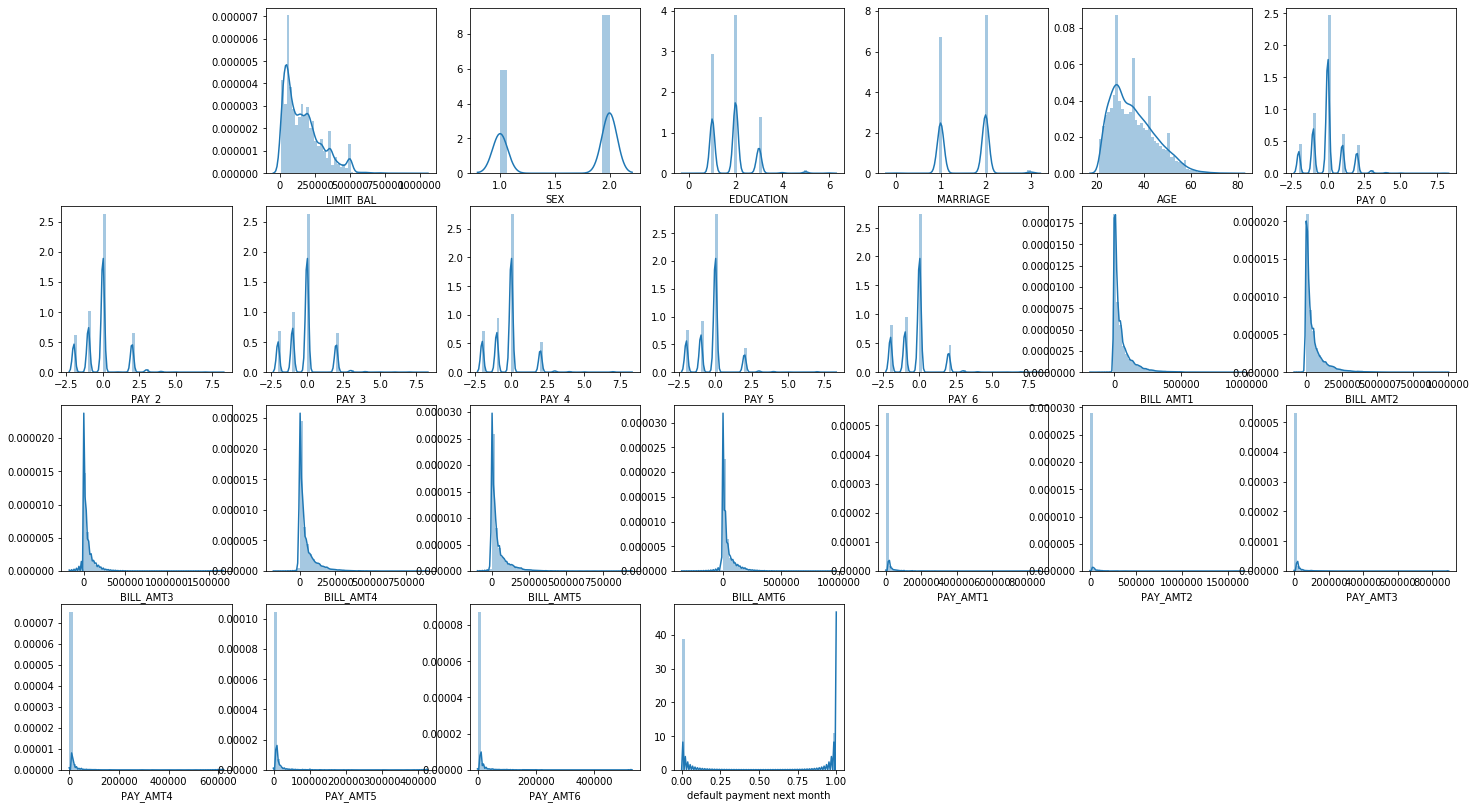

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(25,25))
for i in range(1,len(student_data.columns)):
    plt.subplot(7, 7, i+1)
    sns.distplot(student_data[student_data.columns[i]])

plt.show()

## 2. EDA

## 3. Feature Engineering

## 4. Feature Selection

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

## 6. Model Evaluation

## 7. Final Model